# Time series plotting around reservoirs

## To-dos
- [ ] sum precip from mm/hr to mm
- [ ] convert time series functions & spatial functions to new class

In [3]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [4]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets

In [5]:
fw_DA = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip_DA = load_data.load_IMERG()

In [6]:
def single_timeseries_IMERG_CYGNSS_GRACE(coords_i,**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`
    
    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip_DA , fw_DA , grace_dict
    precip_full = area_subsets.precip_point_subset(coords_i,precip_DA)
    fw_full = area_subsets.cygnss_point_subset(coords_i,fw_DA)
    cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)

    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (12,6)

    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)
    
    return precip , fw , cmwe

In [7]:
res_coords_dict = {
    'merowe' : (18.68 , 32.06),
    'indirasagar' : (22.18,76.6),
    'estreito' : (-6.50001 ,-47.0)
}

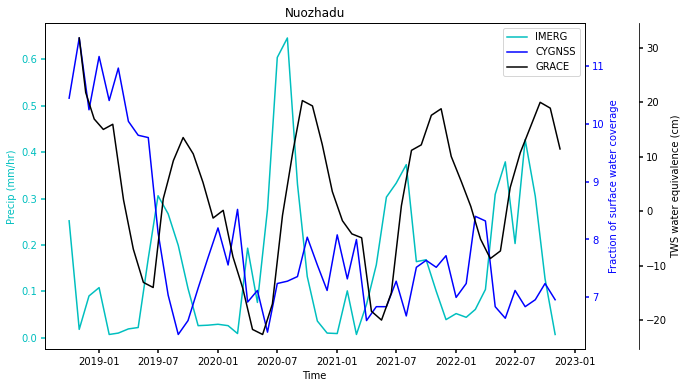

In [52]:
res_oi = 'Nuozhadu'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(area_subsets.reservoir_name_to_point(res_oi,res_shp),**plot_params)

In [53]:
def series_to_TSM_object(input_series,*TSM_args,**TSM_kwargs):
    series_obj = input_series.astype(float)
    series_obj.index = list(map(time_series_calcs.toYearFraction,series_obj.index))
    TSM_obj = time_series_calcs.TimeSeriesMetrics(series_obj,*TSM_args,**TSM_kwargs)
    return TSM_obj

In [54]:
precip_ts = series_to_TSM_object(precip_series,'IMERG')
fw_ts = series_to_TSM_object(fw_series,'CYGNSS')
cmwe_ts = series_to_TSM_object(cmwe_series,'GRACE')

In [56]:
# precip_ts.coef_determination(fw_ts)
# precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
# fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);

---coef of determination----
Between CYGNSS and IMERG
-0.11358138934991313
---coef of determination----
Between GRACE and IMERG
0.0029492861797563164
---coef of determination----
Between GRACE and CYGNSS
0.03636655833899949


## Scratchwork

In [29]:
area_subsets.reservoir_name_to_point('Xiaowan',res_shp) , area_subsets.reservoir_name_to_point('Nuozhadu',res_shp)

((24.706595, 100.093825), (22.640879, 100.429623))

In [33]:
res_shp[res_shp['DAM_NAME'] =='Nuozhadu'].squeeze().head(15)

GRAND_ID          7232
RES_NAME          None
DAM_NAME      Nuozhadu
ALT_NAME          None
RIVER          Lancang
ALT_RIVER       Mekong
MAIN_BASIN      Mekong
SUB_BASIN         None
NEAR_CITY        Pu'er
ALT_CITY          None
ADMIN_UNIT      Yunnan
SEC_ADMIN         None
COUNTRY          China
SEC_CNTRY         None
YEAR              2014
Name: 7162, dtype: object

In [34]:
res_shp[res_shp['ADMIN_UNIT'] == 'Yunnan']

,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,MULTI_DAMS,TIMELINE,COMMENTS,URL,QUALITY,EDITOR,LONG_DD,LAT_DD,POLY_SRC,geometry
5094,5098,None,Shuanghua,None,Trib. Jinsha Jiang,None,Chang Jiang,Jinsha Jiang,Luquan,None,...,None,None,None,None,3: Fair,McGill-BL,102.461897,26.016159,SWBD,"POLYGON ((102.44209 26.03209, 102.44341 26.031..."
5095,5099,None,Haishao,None,Trib. Jinsha Jiang,None,Chang Jiang,Jinsha Jiang,Binchuan,Bingchuan,...,None,None,None,None,2: Good,McGill-BL,100.648745,25.693068,SWBD,"POLYGON ((100.65333 25.69315, 100.65486 25.692..."
5100,5104,None,Xincun,None,Menguo He,None,None,None,Wudin,None,...,None,None,None,None,2: Good,McGill-BL,102.172917,25.501605,SWBD,"POLYGON ((102.17487 25.50237, 102.17621 25.500..."
5102,5106,None,Dumu,None,Trib. Nanpan Jiang,None,Zhu Jiang,None,Mohong,Qujing,...,None,None,Updated year Dec 2018,None,3: Fair,McGill-PB,104.102814,25.298266,GLWD,"POLYGON ((104.14391 25.33762, 104.14258 25.336..."
5114,5118,None,Qiezishan Reservoir,None,Supa,None,Salween,None,Baoshan,None,...,None,None,Updated year Dec 2018,None,3: Fair,McGill-PB,98.809509,24.506716,SWBD,"POLYGON ((98.80032 24.53966, 98.80154 24.53874..."
5115,5119,None,Dongfeng,None,Qu Jiang,Trib. Jinsha Jiang,Chang Jiang,Jinsha Jiang,Yuxi,None,...,None,None,None,None,3: Fair,McGill-BL,102.578208,24.372969,SWBD,"POLYGON ((102.58070 24.37542, 102.58235 24.374..."
6967,7025,None,Ahai,None,Jinsha,None,Yangtzee,None,Ninglang,None,...,None,None,Some records indicate a much smaller reservoir...,https://en.wikipedia.org/wiki/Ahai_Dam,4: Poor,McGill-PB,100.506077,27.352000,JRC,"POLYGON ((100.50518 27.34948, 100.50388 27.350..."
6979,7037,None,Dachaoshan,None,Lacang,None,Mekong,None,Jingdong,None,...,None,None,None,https://en.wikipedia.org/wiki/Dachaoshan_Dam,2: Good,McGill-PB,100.368647,24.027054,JRC,"POLYGON ((100.39575 24.09250, 100.39563 24.090..."
7022,7085,None,Gelantan,None,Lixian,None,Red,None,Jiangcheng,None,...,None,None,None,https://en.wikipedia.org/wiki/Gelantan_Dam,2: Good,McGill-PB,102.056621,22.703891,JRC modified,"POLYGON ((101.99637 22.78862, 101.99663 22.788..."
7024,7087,None,Gongguoqiao,None,Lacang,None,Mekong,None,Yunlong,None,...,None,None,None,https://en.wikipedia.org/wiki/Gongguoqiao_Dam,2: Good,McGill-PB,99.335411,25.585622,JRC,"POLYGON ((99.36487 25.63063, 99.36689 25.63195..."


In [51]:
res_shp.loc[:,['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM
4488,Owen Falls,Uganda,Hydroelectricity,1954,204800.0
4052,Kariba,Zimbabwe,Hydroelectricity,1959,185000.0
5051,Bratsk,Russia,Hydroelectricity,1964,169000.0
4474,High Aswan Dam,Egypt,Irrigation,1970,162000.0
3663,Akosombo Main Dam,Ghana,Hydroelectricity,1965,148000.0
...,...,...,...,...,...
6780,Rangipo,New Zealand,Hydroelectricity,1980,0.2
6801,Lower Manorburn,New Zealand,Irrigation,1933,0.2
4268,Rietport,South Africa,Irrigation,1955,0.1
6787,Lower Karori,New Zealand,Water supply,1872,0.1


In [36]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)

,DAM_NAME,COUNTRY,MAIN_USE,YEAR,CAP_MCM
7162,Nuozhadu,China,Hydroelectricity,2014,23703.0
7213,Xiaowan,China,Hydroelectricity,2012,15043.0
5132,Nam Ngum,Laos,Hydroelectricity,1972,7030.0
6946,Nam Ngum 2,Laos,Hydroelectricity,2011,4230.0
6948,Xe Kaman 1,Laos,Hydroelectricity,2015,3210.0
6944,Nam Theun 2,Laos,Hydroelectricity,2010,3210.0
5145,Ubol Ratana,Thailand,Irrigation,1966,2263.0
5792,Sirindhorn,Thailand,Hydroelectricity,1971,1966.0
7232,Lower Sesan II,Cambodia,Hydroelectricity,2017,1790.0
5146,Lam Pao,Thailand,Irrigation,1969,1430.0
